## Dogs v Cats

In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
import skimage
from skimage import transform

In [2]:
PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [3]:
m = arch(True)

In [4]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [5]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [7]:
learn = ConvLearner.from_model_data(m, data)

In [8]:
learn.freeze_to(-4)

In [9]:
m[-1].trainable

True

In [10]:
m[-4].trainable

True

In [11]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.217423   0.171293   0.9865    



[array([0.17129]), 0.9865]

In [12]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.080495   0.105854   0.9905    



[array([0.10585]), 0.9905]

## Class Activation Maps (CAM)

In [13]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [14]:
x,y = next(iter(data.val_dl))

In [15]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

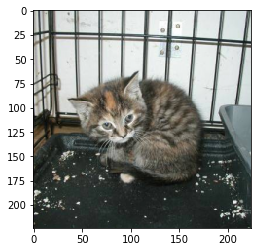

In [16]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [17]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [18]:
%time py = m(Variable(x.cuda()))

CPU times: user 4.1 ms, sys: 12 µs, total: 4.11 ms
Wall time: 3.88 ms


In [19]:
for o in sfs: o.remove()

In [20]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [21]:
py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [22]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [23]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.04194, 0.10448, 0.13124, 0.13748, 0.12924, 0.1033 , 0.04361],
       [0.14565, 0.28678, 0.36148, 0.36353, 0.31678, 0.2244 , 0.1099 ],
       [0.29212, 0.55939, 0.71087, 0.69929, 0.57504, 0.37688, 0.17212],
       [0.40244, 0.77875, 1.     , 0.9797 , 0.78093, 0.47694, 0.20429],
       [0.38737, 0.76309, 0.98441, 0.96694, 0.75708, 0.45119, 0.18265],
       [0.24289, 0.50786, 0.66383, 0.65977, 0.50649, 0.2827 , 0.09171],
       [0.07457, 0.18652, 0.25204, 0.25227, 0.18072, 0.08365, 0.     ]], dtype=float32)

/home/Deep_Learner/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/Deep_Learner/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


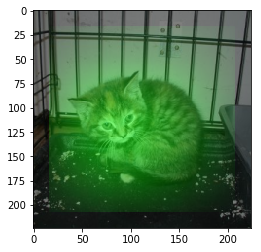

In [26]:
plt.imshow(dx)
plt.imshow(skimage.transform.resize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [27]:
learn.unfreeze()
learn.bn_freeze(True)

In [28]:
# 12 layer groups call for 12 lrs
lr=np.array([[1e-6]*4,[1e-4]*4,[1e-2]*4]).flatten()

In [29]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.072561   0.073025   0.988     
    1      0.049651   0.052888   0.9895                       



[array([0.05289]), 0.9895]

In [30]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.992

In [31]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.026099   0.044954   0.989     
    1      0.017402   0.04339    0.99                         



[array([0.04339]), 0.99]

In [32]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.9925